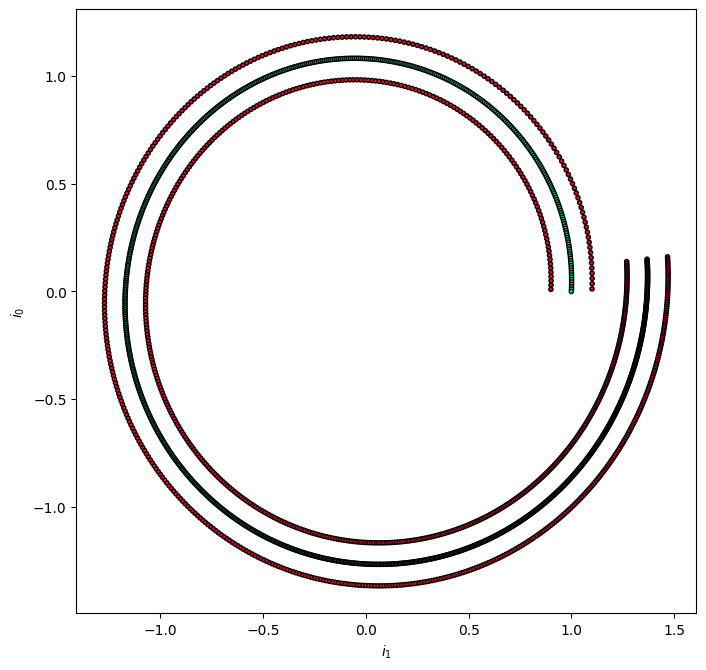

In [1]:
import matplotlib.pyplot as plt
from src.common.train_data import logSpiral2D

train_data, train_labels = logSpiral2D(1, 0.05, 1000, 0.95, 0.1)
n_classes = 2

train_min_y = train_data[:,0].min()
train_max_y = train_data[:,0].max()
train_min_x = train_data[:,1].min()
train_max_x = train_data[:,1].max()

cmap = plt.get_cmap('gist_rainbow')
def colorizeLabel(l):
  return cmap(l/n_classes)

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot()
ax.scatter(train_data[:,1], train_data[:,0], c=colorizeLabel(train_labels), s=9, edgecolor='black')
_ = ax.set_ylabel("$i_0$")
_ = ax.set_xlabel("$i_1$")

Training: 100%|██████████| 300/300 [03:31<00:00,  1.42epoch/s, loss=1401.56, acc=50.00%]


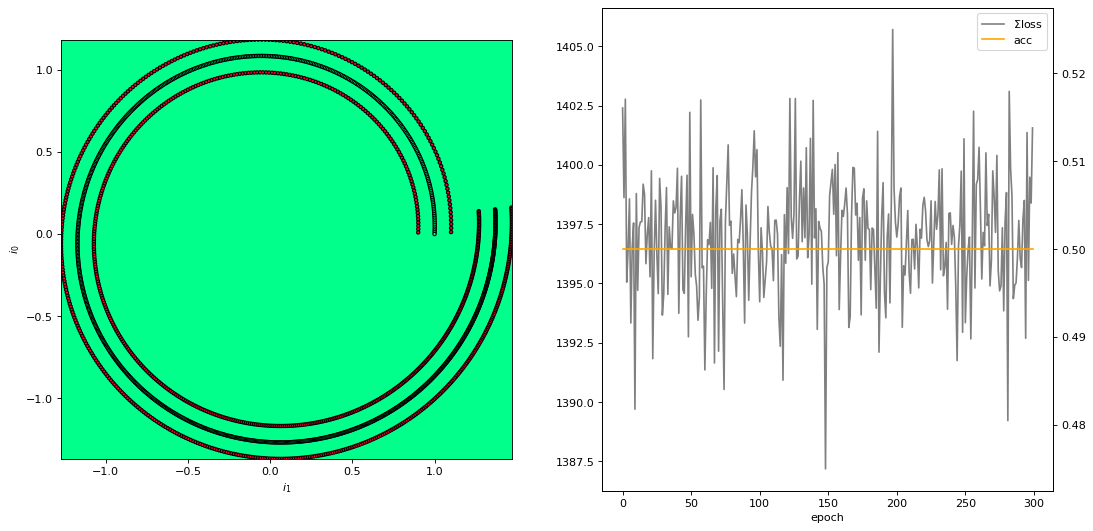

In [18]:
from src.neuronal_network.mlp import MLP
from src.neuronal_network.activation import ReLU, SoftMax
from src.neuronal_network.loss import CrossEntropy
from src.common.vectorize import one_hot
from src.common.plot import sample2DClassifier
import numpy as np
import tqdm


n_epochs = 300
learning_rate = 0.002
momentum = 0.95
batch_size = 1


loss = CrossEntropy()
mlp = MLP(2, [4,4,4,4,4], n_classes, ReLU, SoftMax)

epoch_loss = np.zeros(n_epochs)
epoch_acc  = np.zeros(n_epochs)
epoch_weights = []

train_labels_oh = one_hot(train_labels, n_classes)

with tqdm.tqdm(desc="Training", unit="epoch", total=n_epochs) as progress_bar:
  for epoch in range(n_epochs):
    perm = np.random.permutation(len(train_data))
    data_batches  = np.split(train_data[perm], len(train_data)//batch_size)
    label_batches = np.split(train_labels_oh[perm], len(train_labels_oh)//batch_size)

    epoch_weights.append(mlp.weightsList())

    for batch_data, batch_labels in zip(data_batches, label_batches):
      pred = mlp.forward(batch_data)
      epoch_loss[epoch] += loss(pred, batch_labels).sum()
      mlp.backward(loss.gradient())
      mlp.fit(learning_rate, momentum)


    epoch_acc[epoch] = sum(mlp.classify(train_data) == train_labels) / len(train_data)
    progress_bar.set_postfix_str(f"loss={epoch_loss[epoch]:.02f}, acc={epoch_acc[epoch]*100:.02f}%")
    progress_bar.update(1)


fig = plt.figure(figsize=(16, 8), dpi=80)
ax = fig.subplots(1,2)
ax[0].scatter(train_data[:,1], train_data[:,0], c=colorizeLabel(train_labels), s=9, edgecolor='black')
ax[0].set_ylabel("$i_0$")
ax[0].set_xlabel("$i_1$")
img = ax[0].imshow([[1]])
sample2DClassifier(img, mlp.classify, colorizeLabel,
                   cmap, train_min_y, train_max_y, train_min_x, train_max_x)
ax[1].plot(epoch_loss, label="$\Sigma$loss", color="gray")
ax[1].set_xlabel("epoch")
ax_acc = ax[1].twinx()
ax_acc.plot(epoch_acc, label="acc", color="orange")
_ = fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax_acc.transAxes)


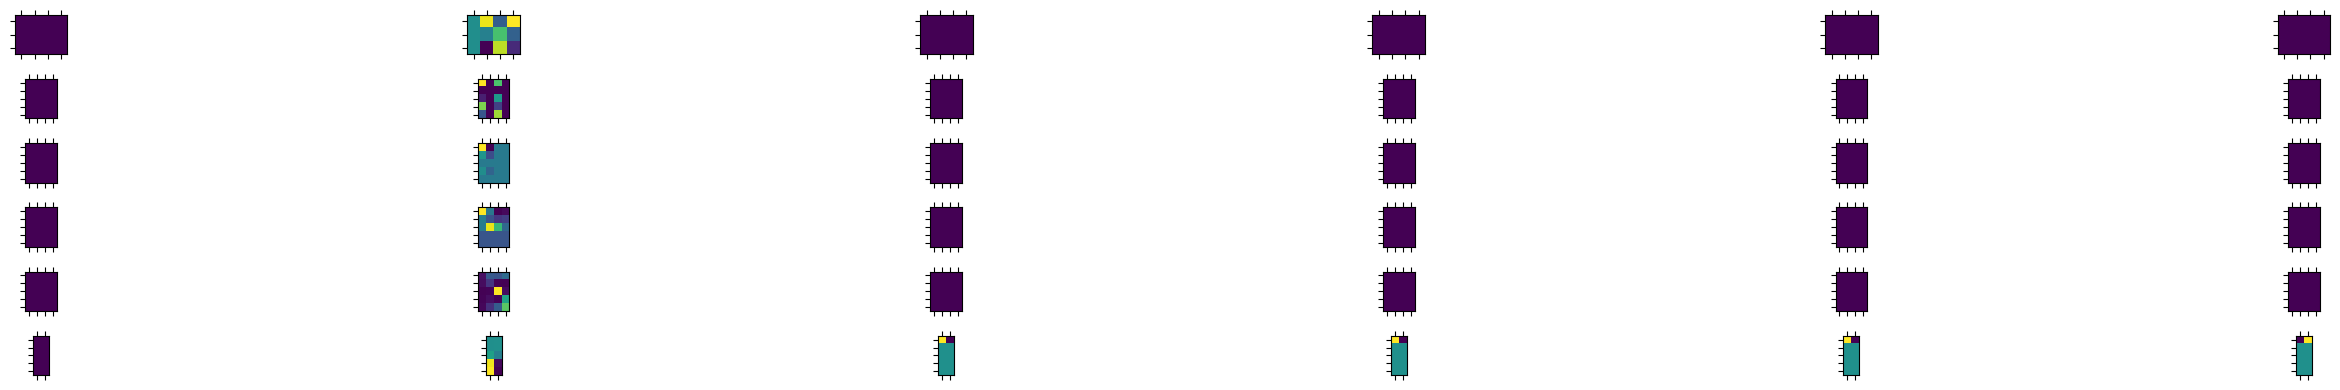

In [15]:
layer_n = len(epoch_weights[0])
show_epochs_n = 6
epoch_weights_selection = epoch_weights[0::n_epochs//show_epochs_n]
fig, ax = plt.subplots(layer_n,len(epoch_weights_selection))
fig.set_tight_layout(True)
fig.set_figwidth(fig.get_figwidth() * 5)
fig.set_dpi(100)

for l in range(0, layer_n):
  lw = None
  for i, ws in enumerate(epoch_weights_selection):
    if lw is None:
      lw = ws[l]
    ax[l][i].matshow(lw-ws[l])
    ax[l][i].set_yticklabels([])
    ax[l][i].set_xticklabels([])
    lw = ws[l]